In [9]:
import random
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

In [10]:
def get_subsimplices(simplicial_complex):
    subsimplices = set()
    for simplex in simplicial_complex:
        for i in range(len(simplex)):
            for sub_simplex in itertools.combinations(simplex, i+1):
                subsimplices.add(tuple(sorted(sub_simplex)))
    return list(subsimplices)

In [11]:
def get_faces(K, d2, d1):
    faces = {}
    for simplex in K:
        if len(simplex) == d2 + 1:
            faces[simplex] = []
            for subset in itertools.combinations(simplex, d1 + 1):
                faces[simplex].append(tuple(sorted(subset)))
    return faces

triangle_1 = [0, 1, 2]
triangle_2 = [2, 3, 4]
triangle_3 = [1, 2, 3]
simplicial_complex = [triangle_1, triangle_2, triangle_3]
d_1 = 1
d_2 = 2
subsimplicies = get_subsimplices(simplicial_complex)
print(subsimplicies)
walk = get_faces(subsimplicies, d_2, d_1)
print(walk)


[(0, 1), (1, 3), (2, 4), (2,), (1, 2), (3, 4), (0, 1, 2), (1, 2, 3), (4,), (2, 3), (1,), (0, 2), (2, 3, 4), (0,), (3,)]
{(0, 1, 2): [(0, 1), (0, 2), (1, 2)], (1, 2, 3): [(1, 2), (1, 3), (2, 3)], (2, 3, 4): [(2, 3), (2, 4), (3, 4)]}


In [12]:
def get_cofaces(K, d1, d2):
    cofaces = {}
    for simplex in K:
        if len(simplex) == d1 + 1:
            cofaces[simplex] = []
            for other_simplex in K:
                if len(other_simplex) == d2 + 1 and set(simplex).issubset(set(other_simplex)):
                    cofaces[simplex].append(other_simplex)
    return cofaces

triangle_1 = [0, 1, 2]
triangle_2 = [2, 3, 4]
triangle_3 = [1, 2, 3]
simplicial_complex = [triangle_1, triangle_2, triangle_3]
d_1 = 1
d_2 = 2
subsimplicies = get_subsimplices(simplicial_complex)
print(subsimplicies)
walk = get_cofaces(subsimplicies, d_1, d_2)
print(walk)


[(0, 1), (1, 3), (2, 4), (2,), (1, 2), (3, 4), (0, 1, 2), (1, 2, 3), (4,), (2, 3), (1,), (0, 2), (2, 3, 4), (0,), (3,)]
{(0, 1): [(0, 1, 2)], (1, 3): [(1, 2, 3)], (2, 4): [(2, 3, 4)], (1, 2): [(0, 1, 2), (1, 2, 3)], (3, 4): [(2, 3, 4)], (2, 3): [(1, 2, 3), (2, 3, 4)], (0, 2): [(0, 1, 2)]}


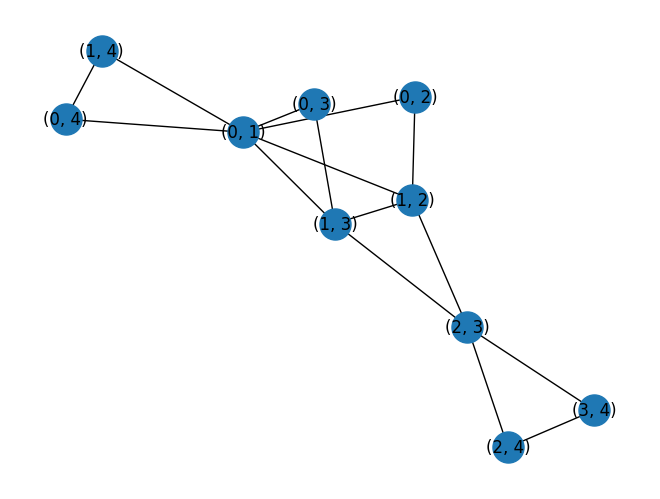

In [13]:
def get_dual_graph(K, d1, d2):
    G = nx.Graph()
    for simplex in K:
        if len(simplex) == d1 + 1:
            G.add_node(simplex)
    for simplex1, simplex2 in itertools.combinations(K, 2):
        if len(simplex1) == d1 + 1 and len(simplex2) == d1 + 1:
            if d1 <= d2:
                common_cofaces = set(get_cofaces(K, d1, d2)[simplex1]).intersection(set(get_cofaces(K, d1, d2)[simplex2]))
                if common_cofaces:
                    G.add_edge(simplex1, simplex2)
            else:
                common_faces = set(get_faces(K, d1, d2)[simplex1]).intersection(set(get_faces(K, d1, d2)[simplex2]))
                if common_faces:
                    G.add_edge(simplex1, simplex2)
    return G

triangle_1 = [0, 1, 2]
triangle_2 = [2, 3, 4]
triangle_3 = [1, 2, 3]
triangle_4 = [0, 1, 4]
triangle_5 = [0, 1, 3]
simplicial_complex = [triangle_1, triangle_2, triangle_3, triangle_4, triangle_5]
d_1 = 1
d_2 = 2
subsimplicies = get_subsimplices(simplicial_complex)
dual_graph = get_dual_graph(subsimplicies, d_1, d_2)
pos = nx.spring_layout(dual_graph)
nx.draw(dual_graph, with_labels=True, pos=nx.spring_layout(dual_graph), node_size=500)
plt.show()


In [14]:
def random_walk_on_simplicial_complex(simplicial_complex, d_1, d_2, l, m=0, n=0, return_prob=False):
    subsimplices = get_subsimplices(simplicial_complex)
    G = get_dual_graph(subsimplices, d_1, d_2)
    nodes = [node for node in subsimplices if len(node) == d_1 + 1]
    start_node = random.choice(nodes)
    walk = [start_node]
    prob = 1.0
    for i in range(l - 1):
        current_node = walk[-1]
        neighbors = list(G.neighbors(current_node))
        if len(neighbors) == 0:
            next_node = start_node
            walk.append(next_node)
            continue
        if random.random() < m:
          if len(walk) > 1:
            walk.append(current_node)
          else:
            walk.append(start_node)
          continue
        if len(walk) > 1 and random.random() < prob * (1-l):
            walk.pop()
            prob /= len(list(G.neighbors(walk[-1])))
            continue
        next_node = random.choice(neighbors)
        if n > 0 and len(walk) > 1 and next_node == walk[-2] and random.random() < n:
            next_node = walk[-1]
        prob /= len(neighbors)
        walk.append(next_node)
    if return_prob:
        return walk,round(prob, 8)
    else:
        return walk

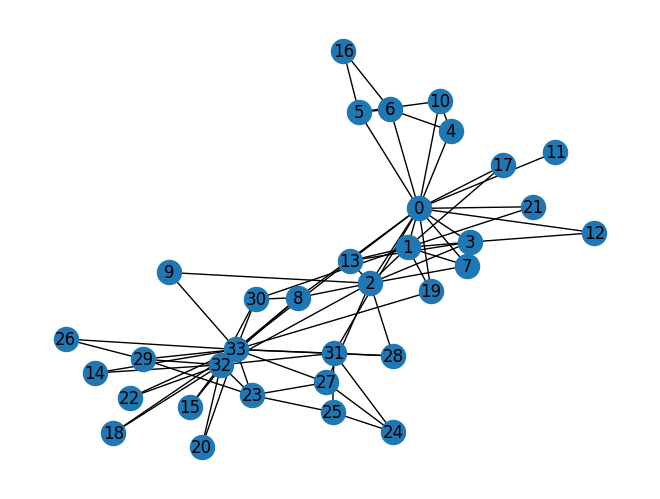

[(20,), (29,), (13,), (22,), (31,), (6,), (15,), (24,), (33,), (8,), (17,), (26,), (1,), (10,), (19,), (28,), (3,), (12,), (21,), (30,), (5,), (14,), (23,), (7,), (16,), (25,), (0,), (9,), (18,), (2,), (11,), (32,), (4,), (27,), (25, 23), (3, 13), (5, 10), (0, 5), (33, 20), (32, 30), (33, 29), (2, 32), (8, 2), (0, 7), (32, 14), (33, 13), (32, 23), (16, 6), (33, 22), (1, 17), (33, 31), (23, 29), (33, 15), (1, 19), (2, 27), (0, 2), (5, 16), (33, 8), (1, 3), (32, 18), (33, 26), (1, 21), (1, 30), (25, 31), (32, 20), (33, 19), (2, 13), (33, 28), (24, 25), (1, 7), (33, 30), (3, 7), (4, 6), (33, 14), (0, 11), (2, 8), (33, 23), (12, 3), (26, 29), (5, 6), (1, 2), (0, 4), (0, 13), (0, 31), (2, 28), (32, 29), (4, 10), (33, 9), (0, 6), (2, 3), (27, 23), (33, 18), (1, 13), (28, 31), (32, 22), (32, 31), (24, 27), (0, 8), (0, 17), (8, 30), (32, 15), (33, 32), (0, 1), (0, 10), (2, 7), (32, 8), (0, 19), (24, 31), (0, 3), (0, 12), (2, 9), (0, 21), (33, 27), (0, 5, 10), (33, 28, 31), (0, 8, 2), (0, 2, 13

In [15]:
def clique_complex(G):
    cliques = list(nx.find_cliques(G))
    simplices = set()
    for c in cliques:
        for i in range(1, len(c) + 1):
            for simplex in itertools.combinations(c, i):
                simplices.add(simplex)
    return sorted(list(simplices), key=len)
G = nx.karate_club_graph()
nx.draw(G, with_labels=True)
plt.show()
simplicial_complex = clique_complex(G)
print(simplicial_complex)
d_1 = 0
d_2 = 1
l = 10
for i in range(10):
  walk = random_walk_on_simplicial_complex(simplicial_complex, d_1, d_2, l, 0.15, 0.15)
  print(walk)

In [8]:
class Classifier(nn.Module):
    def __init__(self, input_channels, output_size, hidden_size):
        super().__init__()
        self.conv1d = nn.Conv1d(in_channels=input_channels, out_channels=hidden_size, kernel_size=1)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(in_features=hidden_size, out_features=output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x) 
        x = self.relu(x)
        x = torch.max(x, dim=2)[0] 
        x = self.linear(x)
        x = self.softmax(x)
        return x

G = nx.karate_club_graph()
clique_complex = clique_complex(G)
d1 = 0
d2 = 1
l = 20
m = 0.15
n = 0.15

num_walks = 34
features = []
for i in range(num_walks):
    walk = random_walk_on_simplicial_complex(clique_complex, d1, d2, l, m, n)
    feature = torch.zeros((l, len(clique_complex)))
    for j, node in enumerate(walk):
        index = next((i for i, v in enumerate(clique_complex) if v == node), None)
        feature[j, index] = 1
    features.append(feature)
features = torch.stack(features)

input_channels = len(clique_complex)
output_size = 2
hidden_size = 60
model = Classifier(input_channels, output_size, hidden_size)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

labels = torch.tensor([0 if G.nodes[node]['club'] == "Mr. Hi" else 1 for node in G.nodes()])

for epoch in tqdm(range(100), desc = "Обучение"):
    optimizer.zero_grad()
    outputs = model(features)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    print('Epoch:', epoch, 'Loss:', loss.item())

with torch.no_grad():
    outputs = model(features)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = roc_auc_score(labels, predicted)
    print('ROCAUC:', accuracy)

Обучение:  34%|███▍      | 34/100 [00:00<00:00, 141.46it/s]

Epoch: 0 Loss: 0.6932629942893982
Epoch: 1 Loss: 0.6928660869598389
Epoch: 2 Loss: 0.6924896240234375
Epoch: 3 Loss: 0.6921176910400391
Epoch: 4 Loss: 0.6917509436607361
Epoch: 5 Loss: 0.691399872303009
Epoch: 6 Loss: 0.6910483241081238
Epoch: 7 Loss: 0.6907000541687012
Epoch: 8 Loss: 0.6903663277626038
Epoch: 9 Loss: 0.6900342106819153
Epoch: 10 Loss: 0.6896890997886658
Epoch: 11 Loss: 0.689338207244873
Epoch: 12 Loss: 0.6889744997024536
Epoch: 13 Loss: 0.6885960102081299
Epoch: 14 Loss: 0.6882075071334839
Epoch: 15 Loss: 0.6878140568733215
Epoch: 16 Loss: 0.6874120831489563
Epoch: 17 Loss: 0.6869993209838867
Epoch: 18 Loss: 0.6865702867507935
Epoch: 19 Loss: 0.6861258149147034
Epoch: 20 Loss: 0.6856666803359985
Epoch: 21 Loss: 0.6851933002471924
Epoch: 22 Loss: 0.6846914887428284
Epoch: 23 Loss: 0.6841688752174377
Epoch: 24 Loss: 0.6836299300193787
Epoch: 25 Loss: 0.6830752491950989
Epoch: 26 Loss: 0.6825039386749268
Epoch: 27 Loss: 0.6819090843200684
Epoch: 28 Loss: 0.68129909038543

Обучение: 100%|██████████| 100/100 [00:00<00:00, 197.61it/s]

Loss: 0.6476196646690369
Epoch: 64 Loss: 0.6462643146514893
Epoch: 65 Loss: 0.6448931694030762
Epoch: 66 Loss: 0.643513560295105
Epoch: 67 Loss: 0.6421112418174744
Epoch: 68 Loss: 0.6406846642494202
Epoch: 69 Loss: 0.6392371654510498
Epoch: 70 Loss: 0.6377574801445007
Epoch: 71 Loss: 0.6362652778625488
Epoch: 72 Loss: 0.6347581148147583
Epoch: 73 Loss: 0.6332406401634216
Epoch: 74 Loss: 0.6316817402839661
Epoch: 75 Loss: 0.6301159858703613
Epoch: 76 Loss: 0.628539502620697
Epoch: 77 Loss: 0.6269346475601196
Epoch: 78 Loss: 0.625303328037262
Epoch: 79 Loss: 0.6236636638641357
Epoch: 80 Loss: 0.6220020055770874
Epoch: 81 Loss: 0.6203439235687256
Epoch: 82 Loss: 0.6186652183532715
Epoch: 83 Loss: 0.616959273815155
Epoch: 84 Loss: 0.6152329444885254
Epoch: 85 Loss: 0.613494336605072
Epoch: 86 Loss: 0.6117558479309082
Epoch: 87 Loss: 0.6100113391876221
Epoch: 88 Loss: 0.6082509756088257
Epoch: 89 Loss: 0.6064854860305786
Epoch: 90 Loss: 0.6046983003616333
Epoch: 91 Loss: 0.6029001474380493
